# Figure 13: NH Sea Ice Volume (SIV) Skill 

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

# import plotting and other utilities from SMYLEutils
from SMYLEutils import calendar_utils as cal
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import regrid_utils as regrid

# import ESP-Lab modules
from esp_lab import data_access
from esp_lab import stats

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Preprocessing:  Data I/O using Dask

### Create Dask Cluster

In [ ]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/core.py", line 502, in handle_comm
    result = await result
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5249, in add_client
    self.remove_client(client=client)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5276, in remove_client
    self.client_releases_keys(
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5014, in client_releases_keys
    self.transitions(recommendations)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 7119, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/glade/wor

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) #adapt(minimum_jobs=0, maximum_jobs=24)

In [5]:
cluster

### Read in CICE monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [6]:
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time','TLAT','TLON','tarea']].drop(['ULAT','ULON'])
    d0 = d0.chunk({'L':-1})
    return d0

In [7]:
%time
# SMYLE-NOV hi data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'hi'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 11
chunk = {}
smyle11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


11.797964912

In [8]:
%%time
smyle11_seas = cal.mon_to_seas_dask2(smyle11).persist()
daskout = wait(smyle11_seas)

CPU times: user 24.6 s, sys: 499 ms, total: 25.1 s
Wall time: 25.9 s


In [9]:
# SMYLE-FEB hi data
startmonth = 2
smyle02 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

11.797964912

In [10]:
%%time
smyle02_seas = cal.mon_to_seas_dask2(smyle02).persist()
daskout = wait(smyle02_seas)

CPU times: user 28.3 s, sys: 517 ms, total: 28.8 s
Wall time: 29.9 s


In [11]:
# SMYLE-MAY hi data
startmonth = 5
smyle05 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle05.nbytes/1e9 #GB

11.797964912

In [12]:
%%time
smyle05_seas = cal.mon_to_seas_dask2(smyle05).persist()
daskout = wait(smyle05_seas)

CPU times: user 32.1 s, sys: 666 ms, total: 32.7 s
Wall time: 36.4 s


In [13]:
# SMYLE-AUG hi data
startmonth = 8
smyle08 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle08.nbytes/1e9 #GB

11.797964912

In [14]:
%%time
smyle08_seas = cal.mon_to_seas_dask2(smyle08).persist()
daskout = wait(smyle08_seas)

CPU times: user 29.7 s, sys: 521 ms, total: 30.2 s
Wall time: 32.1 s


### Get CESM2-LE members

In [15]:
import intake

catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
col = intake.open_esm_datastore(catalog_file)
cesm2data = col.search(component='ice', 
                       variable=['hi'], 
                       frequency='month_1', 
                       experiment=['historical','ssp370'], 
                       forcing_variant='smbb')

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [16]:
## The following is needed as a workaround for this issue with intake-esm:
## https://github.com/intake/intake-esm/issues/343
cesm2data.df = cesm2data.df.sort_values(by=['time_range'])

# Test that it gets timestamps in order:
#cesm2data.df[cesm2data.df.experiment == 'historical']

In [17]:
%%time
## Use preprocessor to return mid-month time
def preproc(ds):
    ds = cal.time_set_midmonth(ds,'time')
    return ds

dask.config.set(**{'array.slicing.split_large_chunks': True})
dsets = cesm2data.to_dataset_dict(preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 11.9 s, sys: 378 ms, total: 12.2 s
Wall time: 15.4 s


In [18]:
dsets.keys()

dict_keys(['ice.historical.cice.h.smbb.hi', 'ice.ssp370.cice.h.smbb.hi'])

In [19]:
# Compute CESM2-LE hi mean over 50 members:
cesm2_hist = dsets['ice.historical.cice.h.smbb.hi'].hi
cesm2_ssp = dsets['ice.ssp370.cice.h.smbb.hi'].hi
cesm2_hi = xr.concat([cesm2_hist,cesm2_ssp],dim='time').mean('member_id').persist()

### Compute SMYLE NH SIV

In [20]:
# Define latitude bounds for computing SIE
lat1 = 40.
lat2 = 90.

In [21]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = (ds.tarea/(1000.**2)).load()
    tarea['units'] = 'km^2'
    tlat = ds.TLAT
    tlon = xr.where(ds.TLON>180.,ds.TLON-360.,ds.TLON)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

In [22]:
POPg16_arctic_area = POP_regional_areawgt(smyle11_seas,[-180.,180.],[lat1,lat2])

- Here, perform actual computation, returning xarray

In [23]:
%%time
m_to_km = 0.001
smyle11_siv = (smyle11_seas.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()
smyle11_time = smyle11_seas.time.load()
smyle02_siv = (smyle02_seas.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()
smyle02_time = smyle02_seas.time.load()
smyle05_siv = (smyle05_seas.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()
smyle05_time = smyle05_seas.time.load()
smyle08_siv = (smyle08_seas.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()
smyle08_time = smyle08_seas.time.load()

CPU times: user 1min 3s, sys: 600 ms, total: 1min 3s
Wall time: 1min 5s


### Store datasets to disk for quicker processing next time 

In [25]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
tmp = smyle11_siv.rename('siv').to_dataset()
tmp['time'] = smyle11_time
tmp['tarea'] = smyle11_seas.tarea.load()
tmp.to_netcdf(outdir+'SMYLE11_SIV_seas.nc')
tmp = smyle02_siv.rename('siv').to_dataset()
tmp['time'] = smyle02_time
tmp['tarea'] = smyle11_seas.tarea.load()
tmp.to_netcdf(outdir+'SMYLE02_SIV_seas.nc')
tmp = smyle05_siv.rename('siv').to_dataset()
tmp['time'] = smyle05_time
tmp['tarea'] = smyle11_seas.tarea.load()
tmp.to_netcdf(outdir+'SMYLE05_SIV_seas.nc')
tmp = smyle08_siv.rename('siv').to_dataset()
tmp['time'] = smyle08_time
tmp['tarea'] = smyle11_seas.tarea.load()
tmp.to_netcdf(outdir+'SMYLE08_SIV_seas.nc')

CPU times: user 205 ms, sys: 10.1 ms, total: 215 ms
Wall time: 236 ms


In [14]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_SIV_seas.nc')
smyle11_sie = smyle11_seas['siv']
smyle11_time = smyle11_seas['time']
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_SIV_seas.nc')
smyle02_sie = smyle02_seas['siv']
smyle02_time = smyle02_seas['time']
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_SIV_seas.nc')
smyle05_sie = smyle05_seas['siv']
smyle05_time = smyle05_seas['time']
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_SIV_seas.nc')
smyle08_sie = smyle08_seas['siv']
smyle08_time = smyle08_seas['time']

### Compute CESM2-LE NH SIV

In [26]:
m_to_km = 0.001
cesm2_siv = (cesm2_hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()

In [27]:
cesm2_siv_seas = cesm2_siv.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

### Compute SMYLE-FOSI NH SIV

In [28]:
ds_fosi = xr.open_dataset('/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ice/proc/tseries/month_1/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.cice.h.hi.030601-036812.nc')
fosi_montime = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)]
ds_fosi['time'] = fosi_montime
fosi_siv = (ds_fosi.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj"))

In [29]:
fosi_siv_seas = fosi_siv.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

### Compute PIOMAS NH SIV

In [30]:
# PIOMAS Gridded Sea Ice Thickness
#ds_obs = xr.open_dataset('/glade/p/cgd/oce/people/yeager/obs/seaice/PIOMAS/PIOMAS.hi.1978-2020.nc',decode_times=False)
#ds_obs['time'] = [cftime.DatetimeNoLeap(1978+year, 1+month, 15) for year in range(43) for month in range(12)]
#obs_hi = ds_obs.hi

# PIOMAS Monthly SIV
fin = '/glade/p/cgd/oce/people/yeager/obs/seaice/PIOMAS/PIOMAS.icevolume.1979-2021.txt'
f = open(fin, 'r')  # We need to re-open the file
xrlist = []
for line in f:
    line = line.strip()
    columns = line.split()
    year = int(columns[0])
    montime = [cftime.DatetimeNoLeap(year, 1+month, 15) for month in range(12)]
    data = [float(columns[i+1])*1000. for i in range(12)]
    siv = xr.DataArray(data,dims=["time"],coords={"time":montime},attrs={"units":"km^3"})
    xrlist.append(siv)
piomas_siv = xr.concat(xrlist,"time")

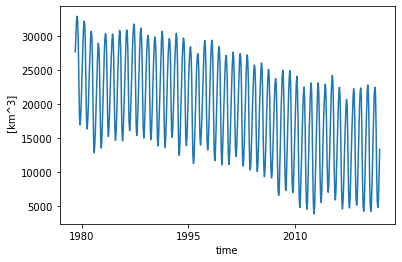

In [31]:
piomas_siv.plot()

In [32]:
obs_siv_seas = piomas_siv.rolling(time=3,min_periods=3, center=True).mean()

# Skill Analysis

In [33]:
# Use bespoke skill score functions for this analysis
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_skill_byseas_withextra(mod_da,mod_time,obs_da,extra_da,cy0,cy1,detrend=False):
    ens = mod_da.mean('M')
    seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}
    r_list = []
    p_list = []
    e_list = []
    r2_list = []
    p2_list = []
    e2_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_time_month = obs_da.time.dt.month
        obs_time_year = obs_da.time.dt.year
        extra_time_month = extra_da.time.dt.month
        extra_time_year = extra_da.time.dt.year
        obs_ts = obs_da.where(obs_time_month==ens_time_month).dropna('time')
        obs_ts = obs_ts.assign_coords(time=("time",obs_ts.time.dt.year.data))
        obs_ts = obs_ts.assign_coords({"season":seasons[ens_time_month]})
        obs_ts = obs_ts - obs_ts.sel(time=slice(cy0,cy1)).mean('time')
        extra_ts = extra_da.where(extra_time_month==ens_time_month).dropna('time')
        extra_ts = extra_ts.assign_coords(time=("time",extra_ts.time.dt.year.data))
        extra_ts = extra_ts.assign_coords({"season":seasons[ens_time_month]})
        extra_ts = extra_ts - extra_ts.sel(time=slice(cy0,cy1)).mean('time')
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b,c = xr.align(ens_ts,obs_ts,extra_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
                c = detrend_linear(c,'time')
        r = xs.pearson_r(a,b,dim='time')
        e = xs.rmse(a,b,dim='time')/b.std('time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r2 = xs.pearson_r(c,b,dim='time')
        e2 = xs.rmse(c,b,dim='time')/b.std('time')
        p2 = xs.pearson_r_eff_p_value(c,b,dim='time')
        r_list.append(r)
        e_list.append(e)
        p_list.append(p)
        r2_list.append(r2)
        e2_list.append(e2)
        p2_list.append(p2)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    rmse = xr.concat(e_list,ens.L)
    corr2 = xr.concat(r2_list,ens.L)
    pval2 = xr.concat(p2_list,ens.L)
    rmse2 = xr.concat(e2_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval,'rmse':rmse,'corr2':corr2,'pval2':pval2,'rmse2':rmse2})

#### De-drift SMYLE data:

In [34]:
%%time
# Remove leadtime-dependent drift, using the following years for climatology:
climy0 = 1980
climy1 = 2015
smyle11_siv_dd,smyle11_siv_drift = stats.remove_drift(smyle11_siv,smyle11_time,climy0,climy1)
smyle02_siv_dd,smyle02_siv_drift = stats.remove_drift(smyle02_siv,smyle02_time,climy0,climy1)
smyle05_siv_dd,smyle05_siv_drift = stats.remove_drift(smyle05_siv,smyle05_time,climy0,climy1)
smyle08_siv_dd,smyle08_siv_drift = stats.remove_drift(smyle08_siv,smyle08_time,climy0,climy1)

CPU times: user 9.52 ms, sys: 71 µs, total: 9.59 ms
Wall time: 9.59 ms


In [35]:
cesm2_siv_seas = cesm2_siv_seas.sel(time=slice("1950","2021"))

In [36]:
%%time
# Correlation as a function of forecast lead month:
smyle11_skill_wfosi = leadtime_skill_byseas_withextra(smyle11_siv_dd,smyle11_time,obs_siv_seas,fosi_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_skill_wfosi = leadtime_skill_byseas_withextra(smyle02_siv_dd,smyle02_time,obs_siv_seas,fosi_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_skill_wfosi = leadtime_skill_byseas_withextra(smyle05_siv_dd,smyle05_time,obs_siv_seas,fosi_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_skill_wfosi = leadtime_skill_byseas_withextra(smyle08_siv_dd,smyle08_time,obs_siv_seas,fosi_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))

smyle11_skill_wfosi_dt = leadtime_skill_byseas_withextra(smyle11_siv_dd,smyle11_time,obs_siv_seas,fosi_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_skill_wfosi_dt = leadtime_skill_byseas_withextra(smyle02_siv_dd,smyle02_time,obs_siv_seas,fosi_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_skill_wfosi_dt = leadtime_skill_byseas_withextra(smyle05_siv_dd,smyle05_time,obs_siv_seas,fosi_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_skill_wfosi_dt = leadtime_skill_byseas_withextra(smyle08_siv_dd,smyle08_time,obs_siv_seas,fosi_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

smyle11_skill_wcesm = leadtime_skill_byseas_withextra(smyle11_siv_dd,smyle11_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_skill_wcesm = leadtime_skill_byseas_withextra(smyle02_siv_dd,smyle02_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_skill_wcesm = leadtime_skill_byseas_withextra(smyle05_siv_dd,smyle05_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_skill_wcesm = leadtime_skill_byseas_withextra(smyle08_siv_dd,smyle08_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))

smyle11_skill_wcesm_dt = leadtime_skill_byseas_withextra(smyle11_siv_dd,smyle11_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_skill_wcesm_dt = leadtime_skill_byseas_withextra(smyle02_siv_dd,smyle02_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_skill_wcesm_dt = leadtime_skill_byseas_withextra(smyle05_siv_dd,smyle05_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_skill_wcesm_dt = leadtime_skill_byseas_withextra(smyle08_siv_dd,smyle08_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encoun

CPU times: user 3.24 s, sys: 11.9 ms, total: 3.25 s
Wall time: 3.34 s


In [37]:
# Correlation as a function of forecast lead month:
smyle11_fosiskill = leadtime_skill_byseas_withextra(smyle11_siv_dd,smyle11_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_fosiskill = leadtime_skill_byseas_withextra(smyle02_siv_dd,smyle02_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_fosiskill = leadtime_skill_byseas_withextra(smyle05_siv_dd,smyle05_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_fosiskill = leadtime_skill_byseas_withextra(smyle08_siv_dd,smyle08_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))

smyle11_fosiskill_dt = leadtime_skill_byseas_withextra(smyle11_siv_dd,smyle11_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_fosiskill_dt = leadtime_skill_byseas_withextra(smyle02_siv_dd,smyle02_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_fosiskill_dt = leadtime_skill_byseas_withextra(smyle05_siv_dd,smyle05_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_fosiskill_dt = leadtime_skill_byseas_withextra(smyle08_siv_dd,smyle08_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encoun

### Collect values for Table 1

In [38]:
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
smyle_skill_wfosi_dt = xr.concat([smyle11_skill_wfosi_dt,smyle02_skill_wfosi_dt,smyle05_skill_wfosi_dt,smyle08_skill_wfosi_dt],dim=startmonth)
smyle_skill_wcesm_dt = xr.concat([smyle11_skill_wcesm_dt,smyle02_skill_wcesm_dt,smyle05_skill_wcesm_dt,smyle08_skill_wcesm_dt],dim=startmonth)
smyle_fosiskill_dt = xr.concat([smyle11_fosiskill_dt,smyle02_fosiskill_dt,smyle05_fosiskill_dt,smyle08_fosiskill_dt],dim=startmonth)

In [40]:
seas = 'JFM'
lkeep = [4,10,16,22]
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('ACC')
    out = [i,da.corr.where(da.season==seas).dropna('L').values, da.pval.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('nRMSE')
    out = [i,da.rmse.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JFM target season (OBS verification):
ACC
[11, array([-0.01801138, -0.44784687]), array([0.93823351, 0.04176109]), array([ 2., 14.])]
[2, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[5, array([-0.35157293, -0.54926566]), array([0.16641557, 0.0223886 ]), array([ 8., 20.])]
[8, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
nRMSE
[11, array([1.46829978, 1.70591994]), array([ 2., 14.])]
[2, array([], dtype=float64), array([], dtype=float64)]
[5, array([1.66399548, 1.76988102]), array([ 8., 20.])]
[8, array([], dtype=float64), array([], dtype=float64)]


In [41]:
seas = 'JFM'
lkeep = [4,10,16,22]
print('Table values for '+seas+' target season (FOSI verification):')
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('ACC')
    out = [i,da.corr.where(da.season==seas).dropna('L').values, da.pval.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('nRMSE')
    out = [i,da.rmse.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JFM target season (FOSI verification):
ACC
[11, array([0.96648864, 0.66778184]), array([2.89270822e-10, 1.78191471e-03]), array([ 2., 14.])]
[2, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[5, array([0.79266592, 0.57404466]), array([0.00072164, 0.02005341]), array([ 8., 20.])]
[8, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
nRMSE
[11, array([0.27405956, 0.79562055]), array([ 2., 14.])]
[2, array([], dtype=float64), array([], dtype=float64)]
[5, array([0.63350508, 0.88383216]), array([ 8., 20.])]
[8, array([], dtype=float64), array([], dtype=float64)]


In [42]:
seas = 'JAS'
lkeep = [4,10,16,22]
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('ACC')
    out = [i,da.corr.where(da.season==seas).dropna('L').values, da.pval.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('nRMSE')
    out = [i,da.rmse.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JAS target season (OBS verification):
ACC
[11, array([-0.26681352, -0.52088855]), array([0.23001248, 0.01547075]), array([ 8., 20.])]
[2, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[5, array([-0.11235083, -0.48088758]), array([0.65714826, 0.05068858]), array([ 2., 14.])]
[8, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
nRMSE
[11, array([1.53255222, 1.6461034 ]), array([ 8., 20.])]
[2, array([], dtype=float64), array([], dtype=float64)]
[5, array([1.43381445, 1.67523351]), array([ 2., 14.])]
[8, array([], dtype=float64), array([], dtype=float64)]


In [43]:
seas = 'JAS'
lkeep = [4,10,16,22]
print('Table values for '+seas+' target season (FOSI verification):')
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('ACC')
    out = [i,da.corr.where(da.season==seas).dropna('L').values, da.pval.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('nRMSE')
    out = [i,da.rmse.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JAS target season (FOSI verification):
ACC
[11, array([0.77689862, 0.50273133]), array([0.00024378, 0.02824837]), array([ 8., 20.])]
[2, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[5, array([0.86882501, 0.6686171 ]), array([0.00011586, 0.00894141]), array([ 2., 14.])]
[8, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
nRMSE
[11, array([0.64518503, 0.94186058]), array([ 8., 20.])]
[2, array([], dtype=float64), array([], dtype=float64)]
[5, array([0.50227658, 0.7721493 ]), array([ 2., 14.])]
[8, array([], dtype=float64), array([], dtype=float64)]


In [46]:
seas = 'JAS'
lkeep = [4,10,16,22]
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('ACC')
    out = [i,da.corr2.where(da.season==seas).dropna('L').values, da.pval2.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_skill_wfosi_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('nRMSE')
    out = [i,da.rmse2.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JAS target season (OBS verification):
ACC
[11, array([0.07523399, 0.07523399]), array([0.75952244, 0.75952244]), array([ 8., 20.])]
[2, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[5, array([0.08102306, 0.07523399]), array([0.74927214, 0.75952244]), array([ 2., 14.])]
[8, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
nRMSE
[11, array([1.33835313, 1.33835313]), array([ 8., 20.])]
[2, array([], dtype=float64), array([], dtype=float64)]
[5, array([1.32314591, 1.33835313]), array([ 2., 14.])]
[8, array([], dtype=float64), array([], dtype=float64)]


In [48]:
seas = 'JFM'
lkeep = [4,10,16,22]
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_skill_wcesm_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('ACC')
    out = [i,da.corr2.where(da.season==seas).dropna('L').values, da.pval2.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_skill_wcesm_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('nRMSE')
    out = [i,da.rmse2.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JFM target season (OBS verification):
ACC
[11, array([0.34301384, 0.35306411]), array([0.25122446, 0.23668277]), array([ 2., 14.])]
[2, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[5, array([0.34301384, 0.35306411]), array([0.25122446, 0.23668277]), array([ 8., 20.])]
[8, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
nRMSE
[11, array([0.94959009, 0.94771345]), array([ 2., 14.])]
[2, array([], dtype=float64), array([], dtype=float64)]
[5, array([0.94959009, 0.94771345]), array([ 8., 20.])]
[8, array([], dtype=float64), array([], dtype=float64)]


In [50]:
seas = 'JAS'
lkeep = [4,10,16,22]
print('Table values for '+seas+' target season (OBS verification):')
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('ACC')
    out = [i,da.corr2.where(da.season==seas).dropna('L').values, da.pval2.where(da.season==seas).dropna('L').values, da.L.where(da.season==seas).dropna('L').values-2]
    print(out)
for i in startmonth.values:
    da = smyle_fosiskill_dt.sel(startmonth=i).sel(L=lkeep)
    if (i==11): print('nRMSE')
    out = [i,da.rmse2.where(da.season==seas).dropna('L').values,  da.L.where(da.season==seas).dropna('L').values-2]
    print(out)

Table values for JAS target season (OBS verification):
ACC
[11, array([-0.0249465, -0.1576516]), array([0.94920575, 0.66358129]), array([ 8., 20.])]
[2, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[5, array([ 0.10528945, -0.0249465 ]), array([0.78747777, 0.94920575]), array([ 2., 14.])]
[8, array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
nRMSE
[11, array([1.08788776, 1.15088345]), array([ 8., 20.])]
[2, array([], dtype=float64), array([], dtype=float64)]
[5, array([1.03856631, 1.08788776]), array([ 2., 14.])]
[8, array([], dtype=float64), array([], dtype=float64)]


### Time Series Plots

In [51]:
scalefact = 1.e-5
## First, compute JFM/JAS anomaly time series from OBS & FOSI & CESM2-LE:
obsmon = obs_siv_seas.time.dt.month
obsjfm = obs_siv_seas.where(obsmon==2).dropna('time')*scalefact
obsjfm = obsjfm.assign_coords(time=("time",obsjfm.time.dt.year.data))
obsjfm = obsjfm - obsjfm.sel(time=slice(climy0,climy1)).mean('time')
obsjas = obs_siv_seas.where(obsmon==8).dropna('time')*scalefact
obsjas = obsjas.assign_coords(time=("time",obsjas.time.dt.year.data))
obsjas = obsjas - obsjas.sel(time=slice(climy0,climy1)).mean('time')

fosimon = fosi_siv_seas.time.dt.month
fosijfm = fosi_siv_seas.where(fosimon==2).dropna('time')*scalefact
fosijfm = fosijfm.assign_coords(time=("time",fosijfm.time.dt.year.data))
fosijfm = fosijfm - fosijfm.sel(time=slice(climy0,climy1)).mean('time')
fosijas = fosi_siv_seas.where(fosimon==8).dropna('time')*scalefact
fosijas = fosijas.assign_coords(time=("time",fosijas.time.dt.year.data))
fosijas = fosijas - fosijas.sel(time=slice(climy0,climy1)).mean('time')

cesm2mon = cesm2_siv_seas.time.dt.month
cesm2jfm = cesm2_siv_seas.where(cesm2mon==2).dropna('time')*scalefact
cesm2jfm = cesm2jfm.assign_coords(time=("time",cesm2jfm.time.dt.year.data))
cesm2jfm = cesm2jfm - cesm2jfm.sel(time=slice(climy0,climy1)).mean('time')
cesm2jas = cesm2_siv_seas.where(cesm2mon==8).dropna('time')*scalefact
cesm2jas = cesm2jas.assign_coords(time=("time",cesm2jas.time.dt.year.data))
cesm2jas = cesm2jas - cesm2jas.sel(time=slice(climy0,climy1)).mean('time')

In [54]:
fosijfm.time

<xarray.DataArray 'time' (time: 63)>
array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020])
Coordinates:
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2016 2017 2018 2019 2020
    units    <U4 'km^2'

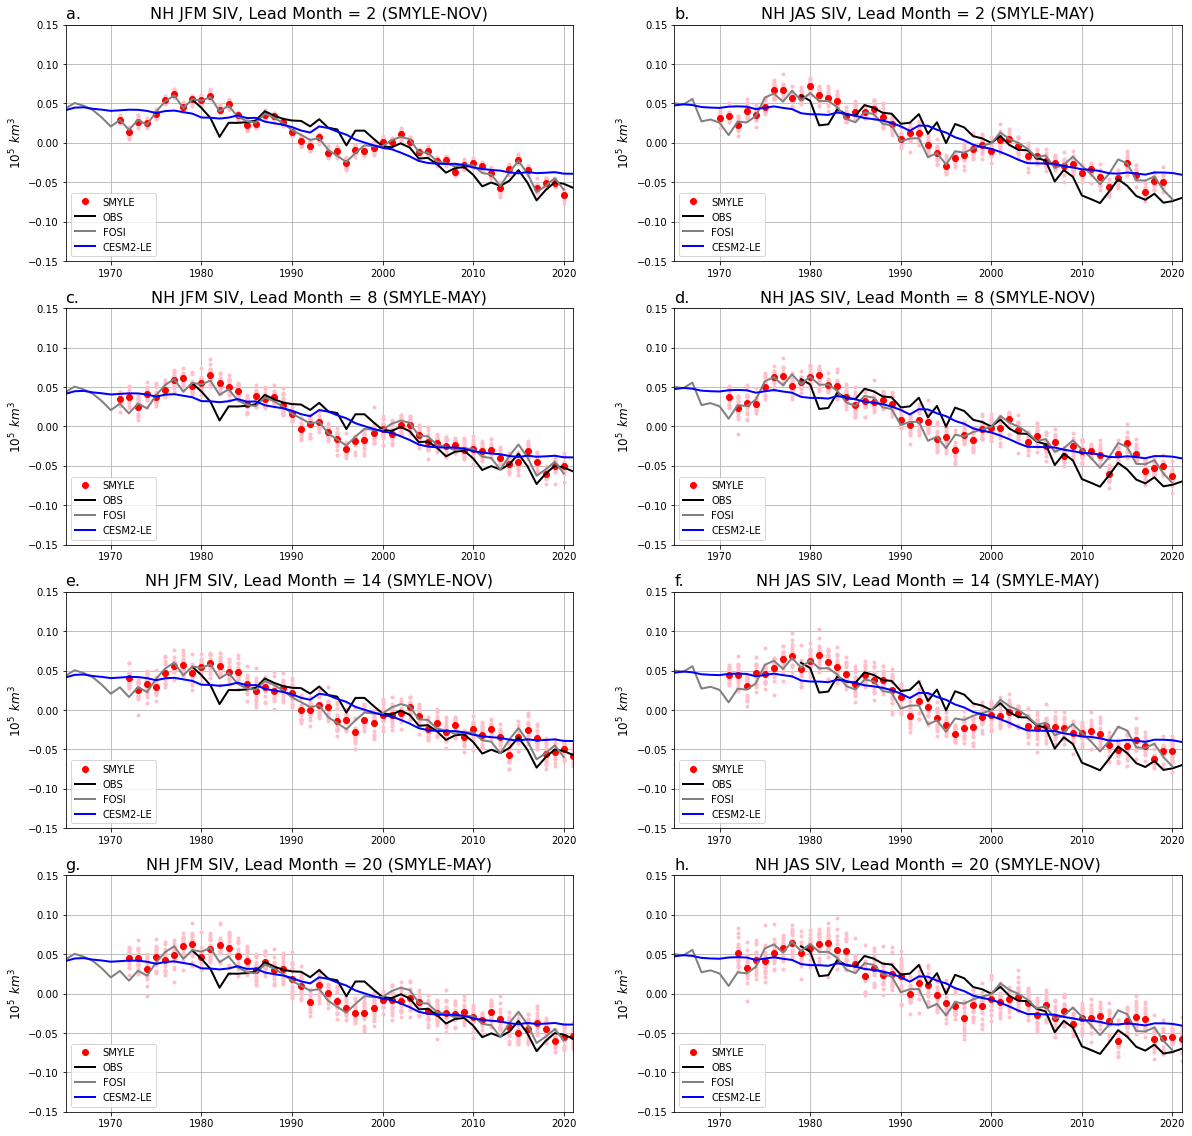

In [57]:
leads = [4,10,16,22]
nlead = np.size(leads)
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2
seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = 1965
xmax = 2021
ymin = -0.15
ymax = 0.15
printskill = False

lead = leads[0]
ax = fig.add_subplot(nrow,ncol,1)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('a.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).corr.data,smyle11_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).corr2.data,smyle11_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).rmse.data,smyle11_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle11_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,2)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('b.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).corr.data,smyle05_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).corr2.data,smyle05_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).rmse.data,smyle05_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle05_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[1]
ax = fig.add_subplot(nrow,ncol,3)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('c.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).corr.data,smyle05_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).corr2.data,smyle05_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).rmse.data,smyle05_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle05_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,4)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('d.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).corr.data,smyle11_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).corr2.data,smyle11_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).rmse.data,smyle11_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle11_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[2]
ax = fig.add_subplot(nrow,ncol,5)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('e.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).corr.data,smyle11_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).corr2.data,smyle11_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).rmse.data,smyle11_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle11_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,6)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('f.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).corr.data,smyle05_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).corr2.data,smyle05_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).rmse.data,smyle05_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle05_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[3]
ax = fig.add_subplot(nrow,ncol,7)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('g.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).corr.data,smyle05_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).corr2.data,smyle05_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wfosi_dt.sel(L=lead).rmse.data,smyle05_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle05_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,8)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('h.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
if (printskill):
    ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).corr.data,smyle11_fosiskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
    ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).corr2.data,smyle11_fosiskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
    ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
    ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wfosi_dt.sel(L=lead).rmse.data,smyle11_fosiskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
    ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_wcesm_dt.sel(L=lead).rmse2.data,smyle11_fosiskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

plt.savefig('f13.png')